In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import pylab as plt
import plot_analysis

import read_data
import trade_indicators
import trade_wallet
import trade_perforpance
import back_test_bot as bb

## Read data

In [3]:
df = read_data.fetch_btc_history(interval="1d", start_date="2016-01-01")

## Compute indicators

In [4]:
df = trade_indicators.detect_all(df, threshold=0.03, rolling_window=6)

## Update trades

In [22]:
df = trade_wallet.make_trades(df, initial_investment=100, trade_fraction_cash=0.2, trade_fraction_volume=0.2)

## Stats
Number of trades

In [30]:
df["direction"].value_counts()

direction
 0    2022
-1     609
 1     466
Name: count, dtype: int64

## Make plots

#### Latest trades

In [12]:
df_sample = df.tail(200)

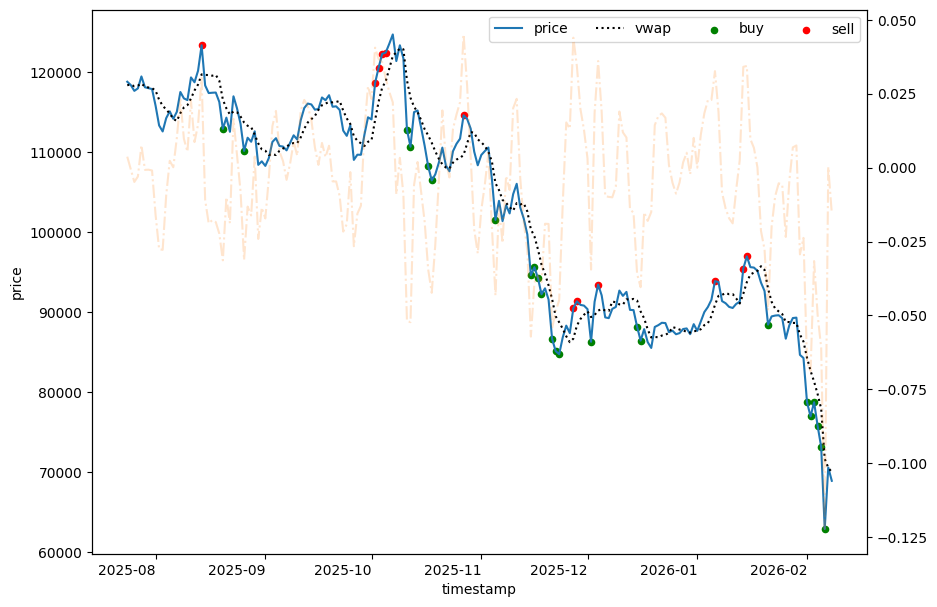

In [27]:
plot_analysis.plot_trade_events(df_sample)

## Wallet growth - Cash value and unit volume

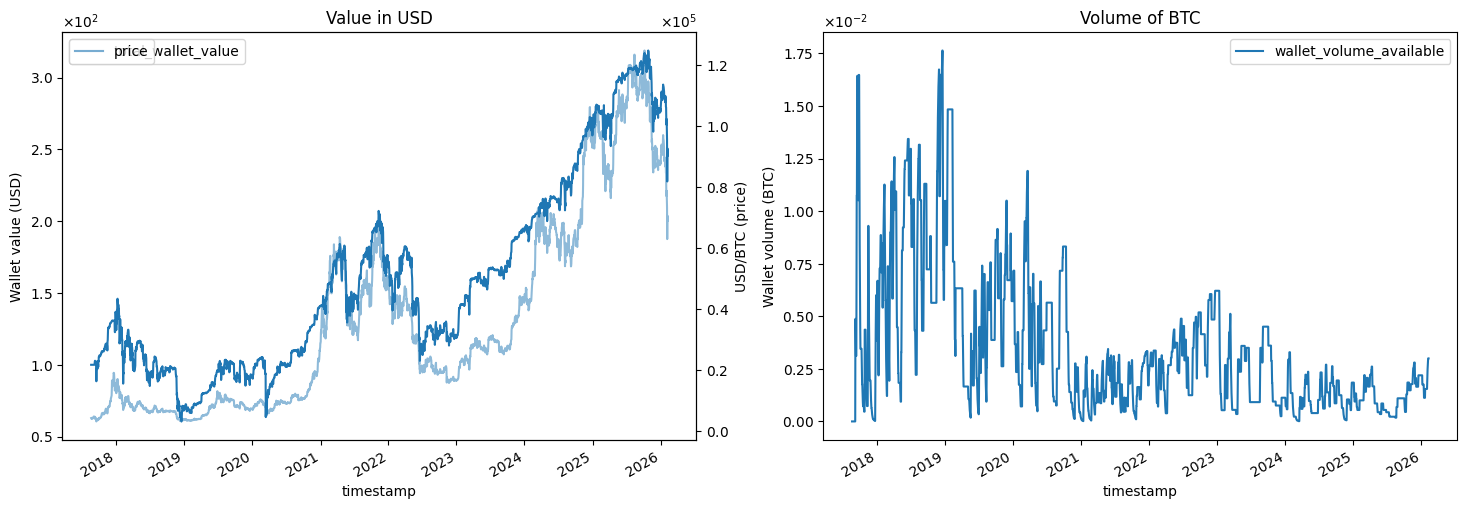

In [34]:
plot_analysis.plot_wallet_outcomes(df)

### Normalised wallet
Compare growth of initial investment

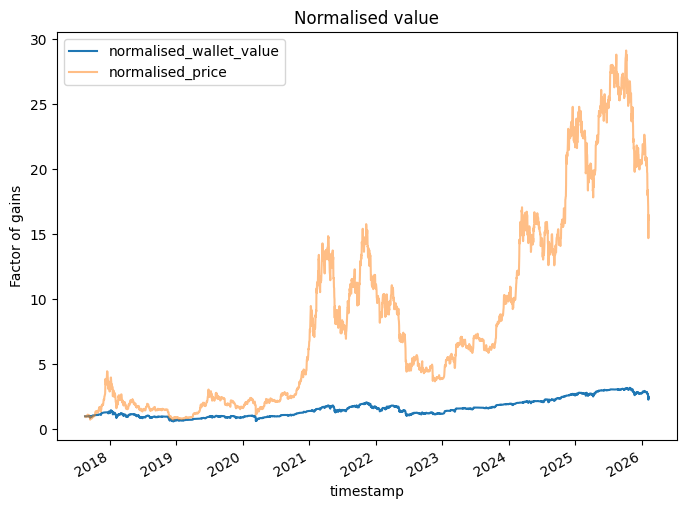

In [33]:
plot_analysis.plot_normalised_wallet(df)

array([[<Axes: title={'center': 'trade_value'}>]], dtype=object)

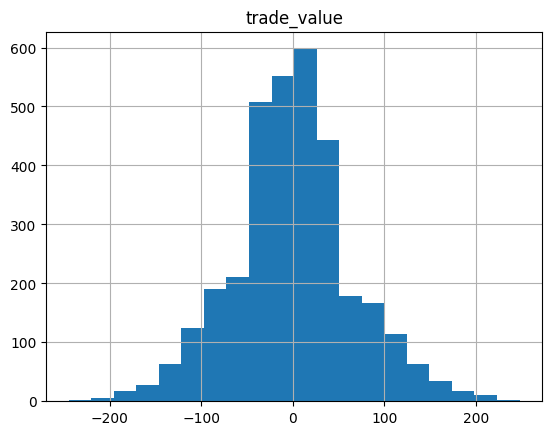

In [89]:
df.loc[df['signal'],['trade_value']].hist(bins=20)

## Fourier transform

In [18]:
# 5. Fourier analysis
price_series = df.set_index("timestamp")["price"]
returns = bb.detrend_series(price_series, method="log_return")

In [19]:
# 14-day rolling FFT on hourly data
fft_window = 24*7
dominant_cycles = bb.dominant_cycle(
    returns,
    window=fft_window,
    sampling_interval=1.0
)

In [20]:
# Align output
cycle_df = pd.DataFrame({
    "timestamp": returns.index[fft_window:],
    "dominant_cycle_hours": dominant_cycles
})

(0.0, 5.0)

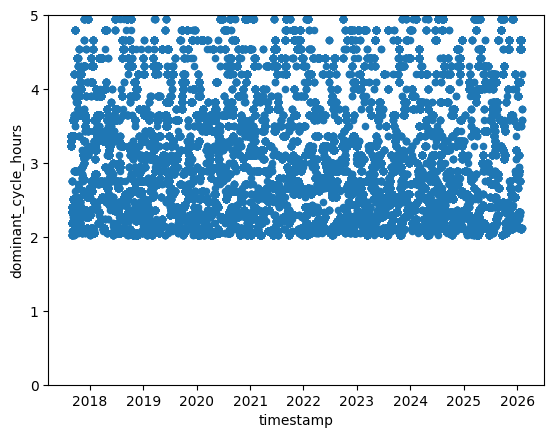

In [21]:
cycle_df.plot.scatter(x='timestamp',y='dominant_cycle_hours')
plt.ylim(0,5)

In [22]:
cycle_df.mean()

timestamp               2021-11-14 15:18:58.703241984
dominant_cycle_hours                         6.831204
dtype: object

In [23]:
cycle_df['dominant_cycle_hours'].value_counts()

dominant_cycle_hours
2.584615      1705
2.333333      1654
3.652174      1607
4.307692      1479
2.896552      1467
              ... 
12.000000      325
24.000000      311
11.200000      301
84.000000      299
168.000000     260
Name: count, Length: 83, dtype: int64

In [24]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/bin/python'